In [1]:
import cnot_network

from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sbs
import numpy as np
sbs.set_context("paper")
sbs.set_theme()
sbs.set_style("dark")

from surface_code_routing.tikz_utils import tikz, tex

sbs.set_context("paper")
sbs.set_theme()
sbs.set_style("dark")
sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

def plt_data(condition, x_axis, y_axis, target=None):
    data = filter(lambda x: x[0] == target, zip(condition, x_axis, y_axis))
    x = []
    y = []
    for _, x_val, y_val in data:
        x.append(x_val)
        y.append(y_val)
    return {'x':x, 'y':y}   


def plt_data_multi(data, x_axis, y_axis, **targets):
    idx_map = {j:i for i, j in enumerate(data)}
    rev_map = {j:i for i, j in idx_map.items()}

    iters = zip(*[iter(data[rev_map[i]]) for i, _ in enumerate(data)])

    x = []
    y = []
    for it in iters:
        checks = True
        for targ in targets:
            if it[idx_map[targ]] != targets[targ]:
                checks = False
        if not checks:
            continue
            
        x.append(it[idx_map[x_axis]])
        y.append(it[idx_map[y_axis]])
    return {'x':x, 'y':y}

In [2]:
from surface_code_routing.instructions import Z_MULTI, Phase, MEAS
from surface_code_routing.symbol import Symbol, ExternSymbol, symbol_map, symbol_resolve
from surface_code_routing.scope import Scope
from surface_code_routing.dag import DAG, DAGNode

from surface_code_routing.qcb import QCB
from surface_code_routing.mapper import QCBMapper
from surface_code_routing.qcb_graph import QCBGraph
from surface_code_routing.qcb_tree import QCBTree
from surface_code_routing.router import QCBRouter
from surface_code_routing.allocator import Allocator
from surface_code_routing.compiled_qcb import CompiledQCB, compile_qcb

from surface_code_routing.instructions import INIT, RESET, CNOT, T_SLICE, Hadamard, Phase, local_Tdag, PREP, MEAS, X

from surface_code_routing.lib_instructions import T_gate, T_Factory
from surface_code_routing.dag import DAG

In [3]:
import itertools
def T_Factory_Lit(*externs, height=5, width=6, t_gate=local_Tdag, n_injection_sites=1, **compiler_arguments):
    '''
        Figure 3
        https://arxiv.org/pdf/1905.06903
        n_injection_sites sets the number of T register sites
    '''

    if 'router_kwargs' in compiler_arguments:
        if 'teleport' not in compiler_arguments:
            compiler_arguments['teleport'] = False
    else:
        router_kwargs = {'teleport': False}
        compiler_arguments['router_kwargs'] = router_kwargs 

    dag = DAG(Symbol('T_Factory', (), 'factory_out'))

    dag.add_gate(INIT(*['t_{i}'.format(i=i) for i in range(n_injection_sites)]))
    dag.add_gate(INIT(*['q_{i}'.format(i=i) for i in range(1, 5)]))

    # Rotate through injection sites
    injection_rotation = itertools.cycle(list(range(n_injection_sites)))

    for i in range(1, 5):  
        targ = 't_{j}'.format(j=next(injection_rotation))
        dag.add_gate(t_gate(targ))
        dag.add_gate(Z_MULTI(targ, f'q_{i}'))
        dag.add_gate(Phase(f'q_{i}'))

    pi8_gates = [
        [1, 2, 3], # 5
        ['factory_out', 1, 2], # 6
        ['factory_out', 1, 3], # 7
        ['factory_out', 2, 3], # 8
        ['factory_out', 3, 4], # 9
        ['factory_out', 1, 4], # 10
        ['factory_out', 2, 4], # 11 
        ['factory_out', 1, 2, 3, 4], # 12
        [2, 3, 4], # 13
        [1, 3, 4], # 14
        [1, 2, 4] # 15
    ]

    for targs in pi8_gates:
        t_targ = 't_{j}'.format(j=next(injection_rotation))
        registers = [[f'q_{i}', f'{i}'][len(str(i)) > 1] for i in targs]

        dag.add_gate(t_gate(t_targ))

        # T gate
        dag.add_gate(Z_MULTI(t_targ, *registers))

        # Phase gate
        dag.add_gate(Z_MULTI(*registers))

    for i in range(1, 5):
        targ = 'q_{i}'.format(i=i)
        dag.add_gate(MEAS(targ))

    qcb_kwargs = compiler_arguments.get('compiled_qcb_kwargs', dict()) 
    qcb_kwargs['readout_operation'] = T_SLICE
    compiler_arguments['compiled_qcb_kwargs'] = qcb_kwargs

    return compile_qcb(dag, height, width, *externs, **compiler_arguments)

In [4]:
for i in range(15):
    try:
        qcb = T_Factory_Lit(height=4, width=5, n_injection_sites=i)
        print(i, 4, qcb.n_cycles(), qcb.space_time_volume())
    except:
        try:
            qcb = T_Factory_Lit(height=5, width=5, n_injection_sites=i)
            print(i, 5, qcb.n_cycles(), qcb.space_time_volume())
        except:
            try:
                qcb = T_Factory_Lit(height=6, width=6, n_injection_sites=i)
                print(i, 6, qcb.n_cycles(), qcb.space_time_volume())
            except:
                pass

1 4 33 385
2 4 33 421
3 4 31 422
4 4 32 458
5 5 33 547
6 5 29 521
7 5 37 668
8 5 37 694
9 6 32 730
10 6 33 746
11 6 32 789
12 6 33 834
13 6 32 843
14 6 34 917


In [5]:
import cnot_network
from functools import partial
from surface_code_routing.lib_instructions import T_Factory, Toffoli, T_gate

toff_height = 14
toff_width = toff_height

qcb_size = 32

t_factory_l1 = cnot_network.T_Factory()
toffoli_gate = cnot_network.Toffoli

t_factory_l2 = T_Factory(t_factory_l1, height=8, width=10, t_gate=T_gate(t_factory_l1))
t_gate_l2 = T_gate(factory=t_factory_l2)

t_factory_l3 = T_Factory(t_factory_l2, height=11, width=12, t_gate=T_gate(t_factory_l2))
t_gate_l3 = T_gate(factory=t_factory_l3)

extern_toffoli_l1 = cnot_network.toffoli(toff_height, toff_width, t_factory=t_factory_l1)
extern_toffoli_l2 = cnot_network.toffoli(toff_height, toff_width, t_factory=t_factory_l2)
extern_toffoli_l3 = cnot_network.toffoli(toff_height, toff_width, t_factory=t_factory_l3)

# Raw T injection sites
ccz_factory_l1 = cnot_network.CCZ_factory(6, 4, t_factory=None)
ccz_factory_l2 = cnot_network.CCZ_factory(9, 7, t_factory=t_factory_l1)
ccz_factory_l3 = cnot_network.CCZ_factory(11, 11, t_factory=t_factory_l2)

t_factory_lit_l1 = T_Factory_Lit(height=4, width=4, n_injection_sites=1)
t_factory_lit_l2 = T_Factory_Lit(t_factory_lit_l1, height=7, width=6, t_gate=T_gate(t_factory_lit_l1), n_injection_sites=1)
t_factory_lit_l3 = T_Factory_Lit(t_factory_lit_l2, height=10, width=7, t_gate=T_gate(t_factory_lit_l2), n_injection_sites=1)

t_factories = (t_factory_l1, t_factory_l2, t_factory_l3)
t_factories_lit = (t_factory_lit_l1, t_factory_lit_l2, t_factory_lit_l3)
extern_toffolis = (extern_toffoli_l1, extern_toffoli_l2, extern_toffoli_l3)
ccz_factories = (ccz_factory_l1, ccz_factory_l2, ccz_factory_l3)

In [28]:
results = {'dist':[], 'runtime':[], 'volume':[], 'size':[], 'ext':[]}
repeats = 5

for size in range(6, 80):
    for _ in range(repeats):
        try:
            qcb = cnot_network.T_Factory(height=5, width=size)
            results['dist'].append(1)
            results['runtime'].append(qcb.n_cycles())
            results['volume'].append(qcb.space_time_volume())
            results['size'].append(size)
            results['ext'].append(0)
            print("\r Constructed 1: ", size, " " * 10, flush=True, end='')
        except:
            print("\r Failed 1: ", size, " " * 10, flush=True, end='')
            pass

for size in range(4, 80):
    for _ in range(repeats):
        try:
            qcb = T_Factory(t_factory_l1, height=9, width=size, t_gate=T_gate(t_factory_l1))
            results['dist'].append(2)
            results['runtime'].append(qcb.n_cycles())
            results['volume'].append(qcb.space_time_volume())
            results['size'].append(size)
            results['ext'].append(len(qcb.dag.physical_externs))
            print("\r Constructed 2: ", size, " " * 10, flush=True, end='')
        except:
            print("\r Failed 2: ", size, " " * 10, flush=True, end='')
            pass

results_cnot = results

 Constructed 2:  79           9            10            16            18            21            26            34            34            24           

In [29]:
results = {'dist':[], 'runtime':[], 'volume':[], 'size':[], 'ext':[]}

repeats = 5

for size in range(4, 80):
    for _ in range(repeats):
        try:
            qcb = T_Factory_Lit(height=5, width=size)
            results['dist'].append(1)
            results['runtime'].append(qcb.n_cycles())
            results['volume'].append(qcb.space_time_volume())
            results['size'].append(size)
            results['ext'].append(0)
            print("\r Constructed 1: ", size, " " * 10, flush=True, end='')
        except:
            print("\r Failed 1: ", size, " " * 10, flush=True, end='')
            pass

for size in range(4, 80):
    for _ in range(repeats):
        try:
            qcb = T_Factory_Lit(t_factory_lit_l1, height=9, width=size, t_gate=T_gate(t_factory_l1), n_injection_sites = min(size // 4, 15))
            results['dist'].append(2)
            results['runtime'].append(qcb.n_cycles())
            results['volume'].append(qcb.space_time_volume())
            results['size'].append(size)
            results['ext'].append(len(qcb.dag.physical_externs))
            print("\r Constructed 2: ", size, " " * 10, flush=True, end='')
        except:
            print("\r Failed 2: ", size, " " * 10, flush=True, end='')
            pass

results_lit = results

 Constructed 2:  79            15            32            59            59           

In [5]:
results = {'dist':[], 'runtime':[], 'volume':[], 'size':[], 'ext':[]}
repeats = 5
for size in range(4, 60):
    for _ in range(repeats):
        try:
            qcb = T_Factory_Lit(t_factory_l1, height=9, width=size, t_gate=T_gate(t_factory_l1), n_injection_sites= min(size // 4, 15))
            results['dist'].append(2)
            results['runtime'].append(qcb.n_cycles())
            results['volume'].append(qcb.space_time_volume())
            results['size'].append(size)
            results['ext'].append(len(qcb.dag.physical_externs))
            print("\r Constructed 2: ", size, " " * 10, flush=True, end='')
        except:
            print("\r Failed 2: ", size, " " * 10, flush=True, end='')
            pass
        
results_hybrid = results

 Failed 2:  79                6            9            9            57           

In [6]:
results = {'dist':[], 'runtime':[], 'volume':[], 'size':[]}

for dist, fact in enumerate(t_factories):
    dist += 1
    gate = T_gate(factory=fact)
    for size in range(5, 60):
        try:
            qcb = T_Factory(fact, t_gate=gate, height=size, width=size)
            results['dist'].append(dist)
            results['runtime'].append(qcb.n_cycles())
            results['volume'].append(qcb.space_time_volume())
            results['size'].append(size)
            print("\r Constructed: ", dist, size, " " * 10, flush=True, end='')
        except:
            print("\r Failed: ", dist, size, " " * 10, flush=True, end='')
            pass

results_nest_cnot = results

 Constructed:  3 59           

In [9]:
results = {'dist':[], 'runtime':[], 'volume':[], 'size':[]}

for dist, fact in enumerate(t_factories_lit):
    dist += 1
    gate = T_gate(factory=fact)
    for size in range(5, 60):
        try:
            qcb = T_Factory_Lit(fact, t_gate=gate, height=size, width=size)
            results['dist'].append(dist)
            results['runtime'].append(qcb.n_cycles())
            results['volume'].append(qcb.space_time_volume())
            results['size'].append(size)
            print("\r Constructed: ", dist, size, " " * 10, flush=True, end='')
        except:
            print("\r Failed: ", dist, size, " " * 10, flush=True, end='')
            pass

results_nest_lit = results

 Constructed:  3 59            1 14           

In [10]:
results = {'dist':[], 'runtime':[], 'volume':[], 'size':[]}

for dist, fact in enumerate(t_factories_lit):
    dist += 1
    gate = T_gate(factory=fact)
    for size in range(5, 60):
        try:
            qcb = T_Factory(fact, t_gate=gate, height=size, width=size)
            results['dist'].append(dist)
            results['runtime'].append(qcb.n_cycles())
            results['volume'].append(qcb.space_time_volume())
            results['size'].append(size)
            print("\r Constructed: ", dist, size, " " * 10, flush=True, end='')
        except:
            print("\r Failed: ", dist, size, " " * 10, flush=True, end='')
            pass

results_nest_hybrid = results

 Constructed:  3 59           1 10            1 14           

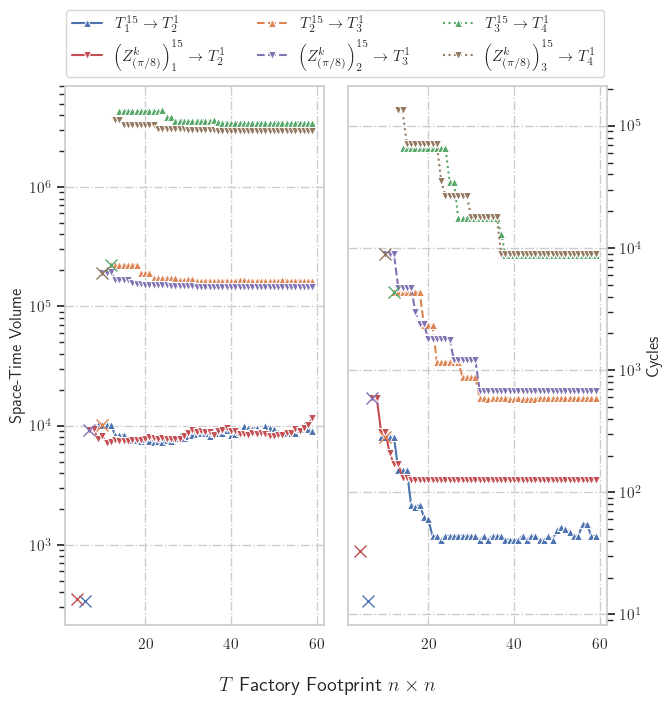

In [13]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

#f, ax = plt.subplots(figsize=(7, 7))


sbs.set_theme()
sbs.set_style("dark")
sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

#locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=20)  
#ax.yaxis.set_minor_locator(locmin)
#ax.yaxis.set_minor_formatter(mticker.NullFormatter())
#plt.grid(True,which="both")  


marks = ['', '.', 'x', '*']
linestyles = ['-', '--', ':']

res = results_nest_cnot
targ_key = 'dist'

dependent = 'volume'
independent = 'size'
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 7))

ax = [
    plt.subplot2grid((1, 4), (0, 0), colspan=2),
    plt.subplot2grid((1, 4), (0, 2), colspan=2)
]

subplot = ax[0]
kwargs = {
'errorbar':('ci', 100)
}

for idx, target in enumerate((1, 2, 3)):
    sbs.lineplot(
        ax=subplot,
        **plt_data(
            res[targ_key],
            res[independent],
            res[dependent],
            target=target
        ),
        label=f'DAG$_{target}$',
        linestyle=linestyles[idx],
        marker='^',
        **kwargs
    )

res = results_nest_lit
for idx, target in enumerate((1, 2, 3)):
    sbs.lineplot(
        ax=subplot,
        **plt_data(
            res[targ_key],
            res[independent],
            res[dependent],
            target=target
        ),
        label=f'DAG$_{target}$',
        linestyle=linestyles[idx],
        marker='v',
        **kwargs
    )

for idx, factory in enumerate(t_factories):
    subplot.plot([max(factory.width, factory.height)], [factory.space_time_volume()], marker='x', color=sbs.color_palette()[idx], markersize=8)

for idx, factory in enumerate(t_factories_lit):
    subplot.plot([max(factory.width, factory.height)], [factory.space_time_volume()], marker='x', color=sbs.color_palette()[idx + 3], markersize=8)


subplot.legend_.remove()
subplot.yaxis.set_label_position("left")
subplot.yaxis.tick_left()
subplot.set_yscale('log')
subplot.set_ylabel('Space-Time Volume')

dependent = 'runtime'

res = results_nest_cnot

subplot = ax[1]
for idx, target in enumerate((1, 2, 3)):
    sbs.lineplot(
        ax=subplot,
        **plt_data(
            res[targ_key],
            res[independent],
            res[dependent],
            target=target
        ),
        label=f'$T^{{15}}_{{{target}}} \\rightarrow T^{{1}}_{{{target + 1}}}$',
        linestyle=linestyles[idx],
        marker='^',
        **kwargs
    )

res = results_nest_lit
for idx, target in enumerate((1, 2, 3)):
    sbs.lineplot(
        ax=subplot,
        **plt_data(
            res[targ_key],
            res[independent],
            res[dependent],
            target=target
        ),
        label=f'$\\left(Z^k_{{(\\pi / 8)}}\\right)^{{15}}_{{{target}}} \\rightarrow T^{{1}}_{{{target + 1}}}$',
        linestyle=linestyles[idx],
        marker='v',
        **kwargs
    )

for idx, factory in enumerate(t_factories):
    subplot.plot([max(factory.width, factory.height)], [factory.n_cycles()], marker='x', color=sbs.color_palette()[idx], markersize = 8)

for idx, factory in enumerate(t_factories_lit):
    subplot.plot([max(factory.width, factory.height)], [factory.n_cycles()], marker='x', color=sbs.color_palette()[idx + 3], markersize = 8)


subplot.legend_.remove()
subplot.yaxis.set_label_position("right")
subplot.yaxis.tick_right()
subplot.set_yscale('log')
subplot.set_ylabel('Cycles')

fig = plt.gcf()
fig.set_size_inches(7, 7)

lines = linestyles * 3

handles, labels = subplot.get_legend_handles_labels()
handles = [handles[0], handles[3], handles[1], handles[4], handles[2], handles[5]]
labels = [labels[0], labels[3], labels[1], labels[4], labels[2], labels[5]]

plt.figlegend(handles, labels, loc='upper left', bbox_to_anchor=(0.11525, 1), ncol=3)

fig.supxlabel('$T$ Factory Footprint $n \\times n$')

plt.savefig('cmp_t_factories.pdf')
